In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np
import math

from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from pandas.plotting import table

In [2]:
tqdm.pandas()

In [3]:
billboard_hot_100 = pd.read_csv("../billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [4]:
plt.rcParams.update({'font.size': 15})

In [5]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

In [6]:
def get_past_weeks(row):
    top_position = row["top_position"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    past_weeks = row[
        (row["first_day_of_the_week"] <= top_position_time)]["weeks_on_chart"].max()
    return past_weeks

def get_future_weeks(row):
    top_position = row["top_position"].iloc[0]
    past_weeks = row["past_weeks"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    max_weeks = row[
        (row["first_day_of_the_week"] > top_position_time)]["weeks_on_chart"].max()
    if max_weeks is np.nan or max_weeks == 0:
        return 0
    future_weeks = max_weeks - past_weeks
    if future_weeks is np.nan or future_weeks < 0:
        return 0
    return future_weeks

In [7]:
df_past_weeks = billboard_hot_100.groupby(["artist", "song_name"]).progress_apply(
    lambda row: get_past_weeks(row)).rename("past_weeks").reset_index()

billboard_hot_100 = billboard_hot_100.merge(df_past_weeks[["artist", "song_name", "past_weeks"]], on=["artist", "song_name"], how="left")

df_future_weeks = billboard_hot_100.groupby(["artist", "song_name"]).progress_apply(
    lambda row: get_future_weeks(row)).rename("future_weeks").reset_index()

billboard_hot_100 = billboard_hot_100.merge(df_future_weeks[["artist", "song_name", "future_weeks"]], on=["artist", "song_name"], how="left")

100%|██████████| 30408/30408 [00:34<00:00, 870.02it/s]


In [8]:
billboard_hot_100["max_weeks_on_chart"] = billboard_hot_100.groupby(["artist", "song_name"])["weeks_on_chart"].transform("max")

billboard_hot_100["first_position"] = billboard_hot_100.sort_values(
    by="first_day_of_the_week").groupby(["artist", "song_name"])["position", "first_day_of_the_week"].transform("first")["position"]
billboard_hot_100["last_position"] = billboard_hot_100.sort_values(
    by="first_day_of_the_week").groupby(["artist", "song_name"])["position", "first_day_of_the_week"].transform("last")["position"]

C:\Users\cutie\AppData\Local\Temp\ipykernel_7896\3272273204.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100["first_position"] = billboard_hot_100.sort_values(
C:\Users\cutie\AppData\Local\Temp\ipykernel_7896\3272273204.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100["last_position"] = billboard_hot_100.sort_values(


In [9]:
billboard_hot_100_copy = billboard_hot_100.copy()
billboard_hot_100 = billboard_hot_100.groupby(
    ["artist", "song_name"])["past_weeks", "top_position", "future_weeks", "max_weeks_on_chart", "year", "first_position", "last_position"].first().reset_index()

C:\Users\cutie\AppData\Local\Temp\ipykernel_7896\4046987392.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100 = billboard_hot_100.groupby(


In [10]:
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["year"] >= 1959) & (billboard_hot_100["year"] <= 2022)]

## Clustering the songs based on the features

In [11]:
# https://napsterinblue.github.io/notes/machine_learning/unsupervised/basic_evaluation_metrics/
def wss_score(model, X):
    sse = 0
    centroids = model.cluster_centers_    

    for point in X:
        centroid = centroids[model.predict(point.reshape(1, -1))]
        sse += np.linalg.norm((centroid - point))
    
    return sse

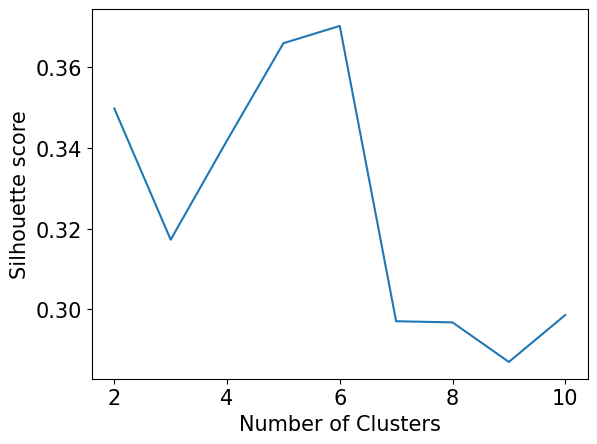

In [12]:
features = ["past_weeks", "top_position", "future_weeks", "max_weeks_on_chart", "first_position", "last_position"]

from sklearn.metrics import silhouette_score

sil = []
kmax = 10

for k in range(2, kmax+1):
    scaler = StandardScaler()
    X = scaler.fit_transform(billboard_hot_100[features])
    kmeans = KMeans(n_clusters = k, n_init="auto").fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))

plt.plot(range(2, kmax + 1), sil)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette score")
plt.savefig("figures\silhouette_score.pdf", format="pdf", bbox_inches="tight")
plt.show()

100%|██████████| 13/13 [01:27<00:00,  6.74s/it]


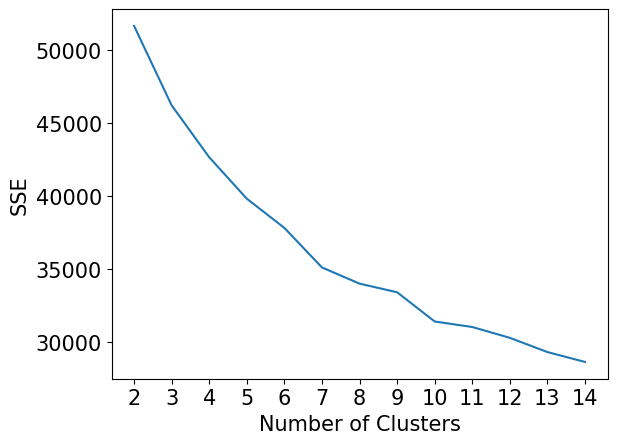

In [13]:
sse = []
for k in tqdm(range(2, 15)):
    kmeans = KMeans(n_clusters=k, n_init="auto")
    scaler = StandardScaler()
    X = scaler.fit_transform(billboard_hot_100[features])
    kmeans.fit(X)
    sse.append(wss_score(kmeans, X))

plt.plot(range(2, 15), sse)
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.savefig("figures/kmeans_sse.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(billboard_hot_100[features])

model = KMeans(n_clusters=5, n_init="auto", random_state=1)
model.fit(X)

y_clusters = model.predict(X)

In [15]:
billboard_hot_100["cluster"] = y_clusters
billboard_hot_100_new = billboard_hot_100[["artist", "song_name", "cluster"]].merge(billboard_hot_100_copy, on=["artist", "song_name"], how="left")

In [16]:
from numpy import unique

unique_clusters = unique(y_clusters)

In [17]:
# classify clusters
cluster_statistics = {}

for cluster in unique_clusters:
    songs_from_cluster = billboard_hot_100_new[billboard_hot_100_new['cluster'] == cluster].copy()
    cluster_statistics[cluster] = songs_from_cluster[["weeks_on_chart", "past_weeks", "future_weeks", "first_position", "last_position", "top_position"]].describe()

brief_cluster = np.argmin([cluster_statistics[i].loc['75%'].loc["weeks_on_chart"] for i in unique_clusters])
start_high_cluster = np.argmin([cluster_statistics[i].loc['75%'].loc["first_position"] for i in unique_clusters])
end_high_cluster = np.argmin([cluster_statistics[i].loc['75%'].loc["last_position"] + cluster_statistics[i].loc['75%'].loc["future_weeks"] for i in unique_clusters])
normal_cluster = np.argmax([cluster_statistics[i].loc['75%'].loc["last_position"] + cluster_statistics[i].loc['75%'].loc["weeks_on_chart"] for i in unique_clusters])
longlasting_cluster = np.argmax([cluster_statistics[i].loc['75%'].loc["weeks_on_chart"] for i in unique_clusters])
print("Brief " + str(brief_cluster))
print("High start " + str(start_high_cluster))
print("High end " + str(end_high_cluster))
print("Normal " + str(normal_cluster))
print("Longlasting " + str(longlasting_cluster))

Brief 4
High start 1
High end 2
Normal 0
Longlasting 3


In [18]:
def map_cluster_name(cluster_nr):
    if cluster_nr == brief_cluster:
        return "Brief songs"
    if cluster_nr == start_high_cluster:
        return "High start songs"
    if cluster_nr == end_high_cluster:
        return "High end songs"
    if cluster_nr == normal_cluster:
        return "Climbing flow songs"
    return "Long-lasting songs"

billboard_hot_100_new["cluster"] = billboard_hot_100_new["cluster"].map(lambda x: map_cluster_name(x))

In [19]:
rows_to_add = []

grouped = billboard_hot_100_new.groupby(["artist", "song_name"])

for name, group in tqdm(grouped):
    max_week = group["first_day_of_the_week"].max()

    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            week = row["first_day_of_the_week"] + timedelta(weeks=1)

            while week <= (max_week + timedelta(weeks=50)):
                rows_to_add.append({
                    "artist": row["artist"],
                    "song_name": row["song_name"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": 101,
                    "first_day_of_the_week": week,
                    "top_position": row["top_position"],
                    "first_position": row["first_position"],
                    "last_position": row["last_position"],
                    "past_weeks": row["past_weeks"],
                    "future_weeks": row["future_weeks"],
                    "max_weeks_on_chart": row["max_weeks_on_chart"],
                    "cluster": row["cluster"],
                    "year": row["year"]
                })
                week += timedelta(weeks=1)

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100_new[["artist", "song_name",
    "weeks_on_chart", "position", "first_day_of_the_week", "top_position",
    "first_position", "last_position", "past_weeks", "future_weeks",
    "max_weeks_on_chart", "cluster", "year"]], pd.DataFrame(rows_to_add)], ignore_index=True)
billboard_100_with_empty_weeks["first_week"] = billboard_100_with_empty_weeks.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")

100%|██████████| 30091/30091 [01:33<00:00, 322.27it/s]


100%|██████████| 5/5 [00:29<00:00,  5.91s/it]


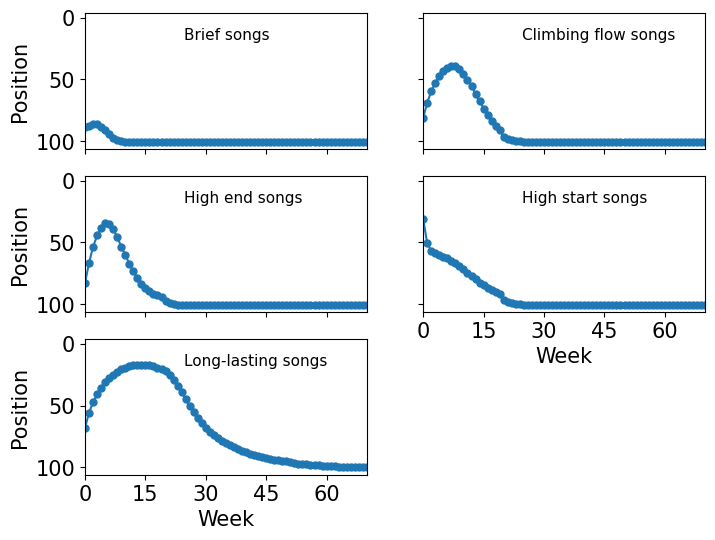

In [20]:
fig, axes = plt.subplots(math.ceil(len(unique_clusters)/2), 2, figsize=(8, 6), sharex=True, sharey=True)
row_i, col_i = 0, 0
unique_clusters = unique(billboard_100_with_empty_weeks['cluster'])

for cluster in tqdm(unique_clusters):
    songs_from_cluster = billboard_100_with_empty_weeks[billboard_100_with_empty_weeks['cluster'] == cluster].copy()
        
    min_first_week = songs_from_cluster["first_day_of_the_week"].min().to_pydatetime()
    songs_from_cluster["first_day_of_the_week"] = songs_from_cluster.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    songs_from_cluster.set_index("first_day_of_the_week", inplace=True)
    songs_from_cluster.sort_index(inplace=True)

    axes[row_i, col_i].plot(songs_from_cluster.groupby("first_day_of_the_week")["position"].mean(),
            marker='o', ms=5)
        
    axes[row_i, col_i].text(0.35, 0.8, f"{cluster}", transform=axes[row_i, col_i].transAxes, fontsize=11)
    if row_i == 2 or ((row_i == 1) and (col_i == 1)):
        axes[row_i, col_i].set_xlabel("Week")
        axes[row_i, col_i].xaxis.set_tick_params(labelbottom=True)
        axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(6))
        for tk in axes[row_i, col_i].get_xticklabels():
                tk.set_visible(True)

    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.delaxes(axes[2, 1])
plt.xlim(0, 70)
plt.gca().invert_yaxis()
plt.savefig("figures/average_cluster_trajectories.pdf", format="pdf", bbox_inches="tight")
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1886.45it/s]


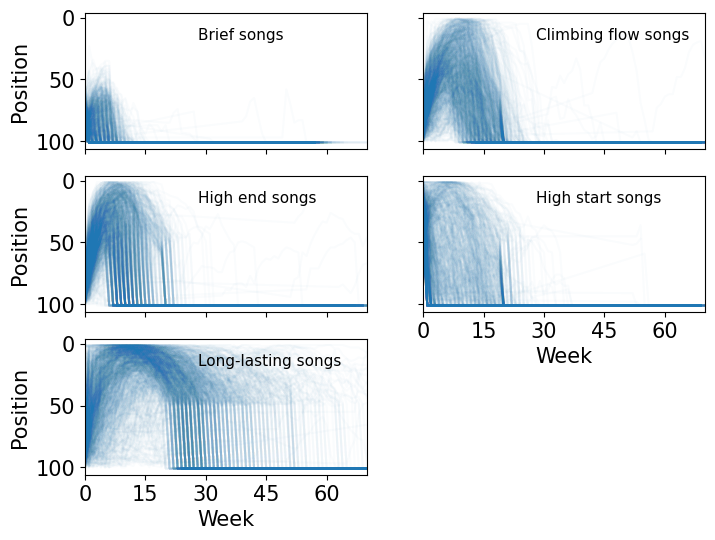

In [21]:
fig, axes = plt.subplots(math.ceil(len(unique_clusters)/2), 2, figsize=(8, 6), sharex=True, sharey=True)
row_i, col_i = 0, 0

for cluster in unique_clusters:
    songs_from_cluster = billboard_100_with_empty_weeks[billboard_100_with_empty_weeks['cluster'] == cluster].copy()
        
    min_first_week = songs_from_cluster["first_day_of_the_week"].min().to_pydatetime()

    songs_from_cluster["first_day_of_the_week"] = songs_from_cluster.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    songs_from_cluster = songs_from_cluster[songs_from_cluster["first_day_of_the_week"] < 80]
    songs_from_cluster.set_index("first_day_of_the_week", inplace=True)
    songs_from_cluster.sort_index(inplace=True)

    first_2000_songs = [g[1] for g in list(songs_from_cluster.groupby(["artist", "song_name"]))[:1000]]
    for song in tqdm(first_2000_songs):
        songs_series = song["position"]
        axes[row_i, col_i].plot(songs_series.index, songs_series.values, alpha=0.02, color="C0")
        
    axes[row_i, col_i].text(0.4, 0.8, f"{cluster}", transform=axes[row_i, col_i].transAxes, fontsize=11)
    if row_i == 2 or ((row_i == 1) and (col_i == 1)):
        axes[row_i, col_i].set_xlabel("Week")
        axes[row_i, col_i].xaxis.set_tick_params(labelbottom=True)
        axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(6))
        for tk in axes[row_i, col_i].get_xticklabels():
            tk.set_visible(True)

    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.delaxes(axes[2, 1])

plt.xlim(0, 70)
plt.gca().invert_yaxis()
plt.savefig("figures/cluster_trajectories.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Percentage of each cluster in time

In [22]:
# Spotify creation date
spotify_creation_date = pd.to_datetime("2008-01-01", infer_datetime_format=True)

# Youtube creation date
youtube_creation_date = pd.to_datetime("2005-02-14", infer_datetime_format=True)

# Apple music creation date
apple_music_creation_date = pd.to_datetime("2015-06-30", infer_datetime_format=True)

# CDs creation date
cds_creation_date = pd.to_datetime("1982-08-17", infer_datetime_format=True)

# MP3 creation date
mp3_creation_date = pd.to_datetime("1991-12-01", infer_datetime_format=True)

# iTunes release date
itunes_creation_date = pd.to_datetime("2001-01-09", infer_datetime_format=True)

# Cassettes creation date
cassettes_creation_date = pd.to_datetime("1963-08-30", infer_datetime_format=True)

# MTV Launch date
mtv_launch_date = pd.to_datetime("1981-08-01", infer_datetime_format=True)

<Figure size 600x400 with 0 Axes>

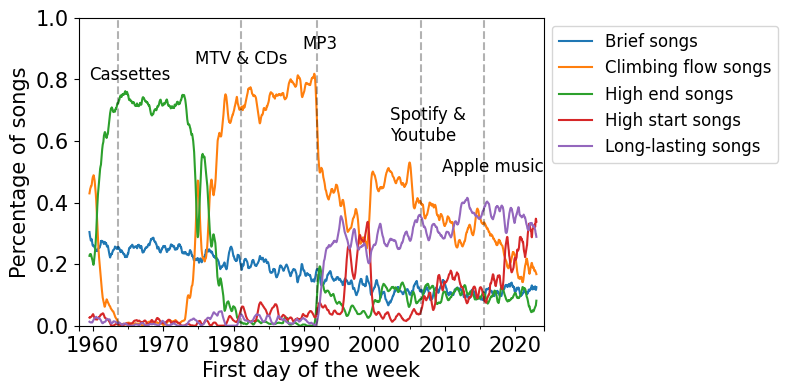

In [23]:
plt.figure(figsize=(6, 4))

billboard_hot_100_new_full_data = billboard_hot_100_new[(billboard_hot_100_new["year"] >= 1959) & (billboard_hot_100_new["year"] <= 2022)]
billboard_hot_100_new_full_data.groupby(["first_day_of_the_week"])["cluster"].value_counts(
    normalize=True).unstack(fill_value=0).stack().sort_index().unstack().rolling(window=30).mean().plot(figsize=(6, 4))

plt.axvline(x = youtube_creation_date + timedelta(days=(spotify_creation_date - youtube_creation_date).days/2),
                                color='black', ls="dashed", alpha=0.3)
plt.axvline(x = apple_music_creation_date, color='black', ls="dashed", alpha=0.3)
plt.axvline(x = mtv_launch_date + timedelta(days=(mtv_launch_date - cds_creation_date).days/2), color='black',
                                ls="dashed", alpha=0.3)
plt.axvline(x = mp3_creation_date, color='black', ls="dashed", alpha=0.3)
plt.axvline(x = cassettes_creation_date, color="black", ls="dashed", alpha=0.3)

plt.text(youtube_creation_date - timedelta(weeks=150), 0.6, "Spotify &\nYoutube", fontsize=12)
plt.text(apple_music_creation_date - timedelta(weeks=310), 0.5, "Apple music", fontsize=12)
plt.text(mtv_launch_date - timedelta(weeks=370), 0.85, "MTV & CDs", fontsize=12)
plt.text(mp3_creation_date - timedelta(weeks=110), 0.9, "MP3", fontsize=12)
plt.text(cassettes_creation_date - timedelta(weeks=220), 0.8, "Cassettes", fontsize=12)

plt.ylabel("Percentage of songs")
plt.xlabel("First day of the week")
plt.xlim(datetime(1958, 1, 1), datetime(2024, 1, 1))
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1, 1), fontsize=12)
plt.savefig("figures/percentage_of_songs_by_cluster.pdf", format="pdf", bbox_inches="tight")
plt.show()

Cluster Brief songs
          Unnamed: 0      position  last_week_position  peak_position  \
count   57405.000000  57405.000000        43787.000000   57405.000000   
mean   138363.192387     81.369027           79.513326      77.117063   
std     93707.628996     13.314889           13.265539      14.022371   
min      2171.000000     20.000000           20.000000      20.000000   
25%     58663.000000     72.000000           70.000000      67.000000   
50%    121767.000000     84.000000           81.000000      78.000000   
75%    208299.000000     93.000000           90.000000      89.000000   
max    336186.000000    100.000000          100.000000     100.000000   

       weeks_on_chart          year  top_position    past_weeks  future_weeks  \
count    57405.000000  57405.000000  57405.000000  57405.000000  57405.000000   
mean         3.759272   1984.572633     71.772964      4.279314      2.239544   
std          2.500179     17.950484     13.921684      2.036586      2.139917  

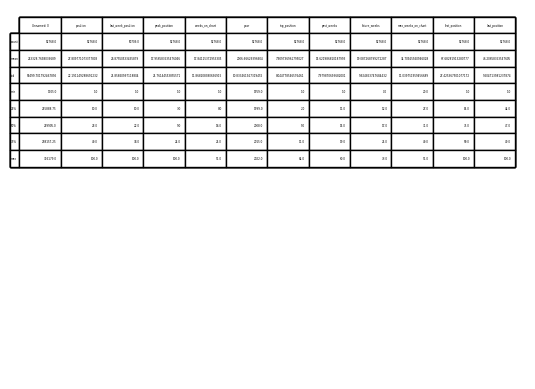

In [24]:
for cluster in unique_clusters:
    songs_from_cluster = billboard_hot_100_new_full_data[billboard_hot_100_new_full_data['cluster'] == cluster].copy()
    print(f"Cluster {cluster}")
    cluster_subdf = songs_from_cluster[["artist", "song_name", "weeks_on_chart", "past_weeks", "future_weeks", "first_position", "last_position", "top_position"]].drop_duplicates()
    cluster_describe = songs_from_cluster.describe()
    print(cluster_describe)

    #https://stackoverflow.com/questions/48158688/save-pandas-describe-for-human-readibility
    #create a subplot without frame
    plot = plt.subplot(111, frame_on=False)

    #remove axis
    plot.xaxis.set_visible(False) 
    plot.yaxis.set_visible(False) 

    #create the table plot and position it in the upper left corner
    table(plot, cluster_describe, loc='upper right')
    #save the plot as a png file
    plt.savefig(f'figures/cluster_{cluster}.pdf', format="pdf")


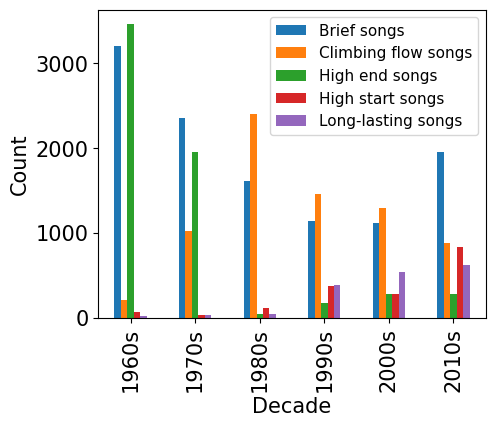

In [25]:
billboard_hot_100_new["year"] = billboard_hot_100_new["first_day_of_the_week"].dt.year
billboard_hot_100_new["decade"] = billboard_hot_100_new["year"].apply(lambda x: x - x % 10).map(str) + "s"
billboard_hot_100_new = billboard_hot_100_new[(billboard_hot_100_new["decade"] != "2020s") &\
                                                (billboard_hot_100_new["decade"] != "1950s")].copy()

billboard_hot_100_new[["decade", "cluster", "song_name", "artist"]].drop_duplicates().groupby(
    "decade")["cluster"].value_counts().unstack().plot(kind="bar", figsize=(5, 4))

plt.ylabel("Count")
plt.xlabel("Decade")
plt.legend(fontsize=11)
plt.savefig("figures/cluster_count_by_decade.pdf", format="pdf", bbox_inches="tight")
plt.show()